Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune PaliGemma 2 with Keras

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma_2/Finetune_PaliGemma_2_with_Keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/google-gemini/gemma-cookbook/PaliGemma_2/Finetune_PaliGemma_2_with_Keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

This notebook shows how to fine-tune [PaliGemma 2](https://ai.google.dev/gemma/docs/paligemma) on a vision-language task with [Keras](https://keras.io/). Fine-tuning is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

## Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with Keras, but basic knowledge about Keras (or similar technologies) is helpful when reading through the example code.e.

## Install KerasHub

In [2]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [3]:
!pip install -q -U keras keras-hub

import os
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# Set the fine-tuning variables
BATCH_SIZE = 1
TRAIN_EXAMPLES = 4
LEARNING_RATE = 0.003

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

## Download the training and validation data

In [4]:
import io
import json
import os
import urllib

import base64
import html

import numpy as np
import keras
import keras_hub
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from PIL import Image

train_file = urllib.request.urlopen(
    "https://storage.googleapis.com/longcap100/data_train90.jsonl"
)
val_file = urllib.request.urlopen(
    "https://storage.googleapis.com/longcap100/data_val10.jsonl"
)

# Crop the image to the desired dimensions.
target_size = (224, 224)

def load_image(image_url):
    image = tf.io.decode_jpeg(urllib.request.urlopen(image_url).read())
    return tf.image.resize(image, size=target_size)

def load_dataset(file):
    captions = []
    images = []
    for line in file:
        sample = json.loads(line)
        captions.append(sample["suffix"])
        image_name = sample["image"]
        image_url = f"https://storage.googleapis.com/longcap100/{image_name}"
        images.append(load_image(image_url))
    return tf.data.Dataset.from_tensor_slices({
        "images": images,
        "prompts": ["caption en\n"] * len(images),
        "responses": captions,
    })

train_data = load_dataset(train_file).shuffle(1000).batch(BATCH_SIZE)
val_data = load_dataset(val_file).shuffle(1000).batch(BATCH_SIZE)

/tmp/ipykernel_23/4203520384.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

Training examples



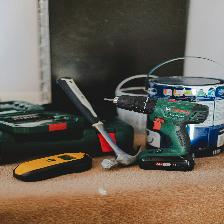
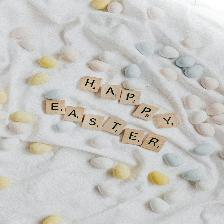
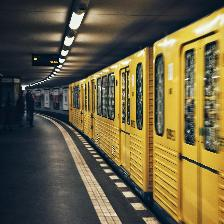
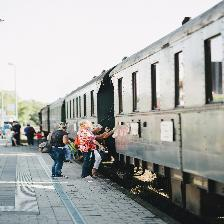
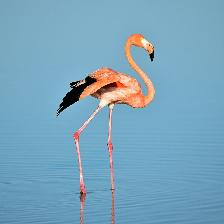
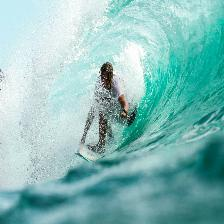
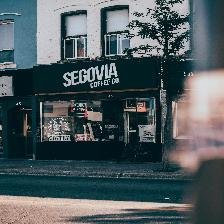
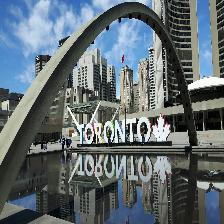

In [5]:
def render_inline(image, resize=(224, 224)):
  """Convert image into inline html."""
  image = tf.keras.preprocessing.image.array_to_img(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = np.asarray(image)
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""

for element in train_data.take(8):
  caption = tf.compat.as_str_any(element["responses"].numpy()[0])
  html_out += render_example(element["images"].numpy()[0], caption)

print("Training examples")
display(HTML(html_out))

## Load Model

In [6]:
pali_gemma_lm = keras_hub.models.PaliGemmaCausalLM.from_preset(
    "/kaggle/input/paligemma2/keras/pali_gemma2_pt_3b_224/1"
#    "kaggle://keras/paligemma2/keras/pali_gemma2_pt_3b_224"
)
pali_gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,032,094,960 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,032,094,960 (11.30 GB)

 Trainable params: 3,032,094,960 (11.30 GB)

 Non-trainable params: 0 (0.00 B)

## Inference before fine tuning


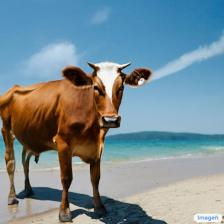


Inference Result



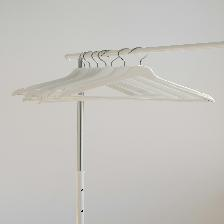
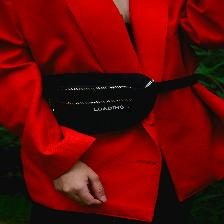
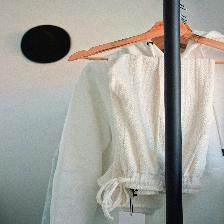
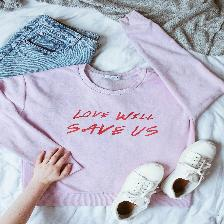

In [7]:
test_image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
test_image = load_image(test_image_url)

def inference_test(image):
  prompt = 'caption en\n'
  output = pali_gemma_lm.generate(
      inputs={
          "images": image,
          "prompts": prompt,
      }
  )
  return render_example(image, output)

display(HTML(inference_test(test_image)))


def make_predictions():
  html_out = ""
  for element in val_data.take(4):
    html_out += inference_test(element["images"].numpy()[0])

  print("\nInference Result")
  display(HTML(html_out))

make_predictions()

## LoRA Fine-tuning

In [8]:
# Enable lora to freeze most of the model and save memory.
pali_gemma_lm.backbone.enable_lora(4)
pali_gemma_lm.summary()

# Lower our sequence length to further save memory.
pali_gemma_lm.preprocessor.sequence_length = 64

# Use Cosine Decay Scheduler with Warm up
#cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
#    initial_learning_rate = 0,
#    decay_steps = TRAIN_EXAMPLES,
#    warmup_target = LEARNING_RATE,
#    warmup_steps = TRAIN_EXAMPLES / 10
#)

def plot_scheduler(step, scheduler):
  x = range(step)
  y = []
  for step in x:
    y.append(scheduler(step))
  plt.plot(x, y, label=scheduler.name)
  plt.xlabel('Epoch')
  plt.ylabel('Learning Rate')
  plt.legend()
  plt.show()

#plot_scheduler(TRAIN_EXAMPLES, cosine_decay_scheduler)

# Use AdamW (a common optimizer for transformer models).
#optimizer = keras.optimizers.SGD(learning_rate=cosine_decay_scheduler)
optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

pali_gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,035,023,600 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,035,023,600 (11.31 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 3,032,094,960 (11.30 GB)

## Fine-tune the model

Epoch 1/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 117s 877ms/step - loss: 1.6715 - sparse_categorical_accuracy: 0.5523
Epoch 2/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 567ms/step - loss: 0.9483 - sparse_categorical_accuracy: 0.6871
Epoch 3/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 555ms/step - loss: 0.7245 - sparse_categorical_accuracy: 0.7587
Epoch 4/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 555ms/step - loss: 0.5710 - sparse_categorical_accuracy: 0.8049


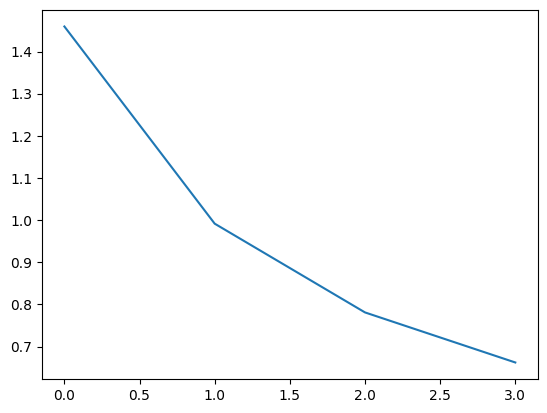

In [9]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if(epoch % EVAL_STEPS == EVAL_STEPS-1):
          # Evaluate
          display(HTML(inference_test(test_image)))
          make_predictions()

#history = pali_gemma_lm.fit(train_data, epochs=TRAIN_STEPS, callbacks=[CustomCallback()])
history = pali_gemma_lm.fit(train_data, epochs=TRAIN_STEPS)
plt.plot(history.history['loss'])
plt.show()

## Output

The validation data for this notebook consists of just 10 images. In normal code, you would likely have many more data points for validation, but for this notebook, run the following code to generate descriptions for all 10 images. After tuning the model, these descriptions should be very similar in form and content coverage to the descriptions included with the training data that you looked at earlier in this notebook.

Run the below code to generate descriptions for the validation data set.


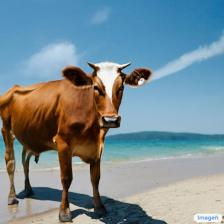


Inference Result



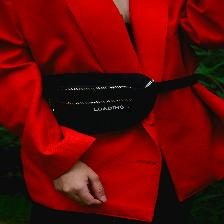
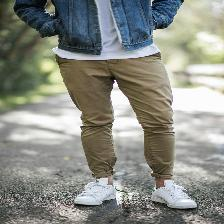
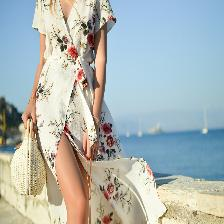
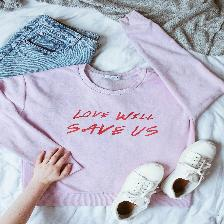

In [10]:
display(HTML(inference_test(test_image)))
make_predictions()